# Performances and Statistical Test
Perform t-tests to compute statistical significance between performances values.

In [1]:
from Utils import load_data, model_performances
import pandas as pd
import glob
import numpy as np
from scipy.stats import ttest_rel
from sklearn.metrics import classification_report, roc_auc_score
import collections
import json

In [2]:
# ________________________________________Utils _______________________________________________________
MODELNAMES_M_MTC = ['multimodal_text_captions_BO_v{}'.format(i) for i in range(10)]
MODELNAMES_M_MTT = ['multimodal_text_tags_BO_v{}'.format(i) for i in range(10)]
MODELNAMES_MTC = ['multimodal_text_captions_v{}'.format(i) for i in range(10)]
MODELNAMES_MTT = ['multimodal_text_tags_v{}'.format(i) for i in range(10)]
MODELNAMES_VISUAL_BERT = ['model_VisualBERT_v{}'.format(i) for i in range(10)]
MODELNAMES_BERT = ['model_BERT_v{}'.format(i) for i in range(10)]

In [3]:
MODELFAMILIES =  [MODELNAMES_M_MTC] + [MODELNAMES_MTC] + [MODELNAMES_MTT]+ [MODELNAMES_M_MTT]+ [MODELNAMES_VISUAL_BERT] + [MODELNAMES_BERT]

models = []
for x in MODELFAMILIES:
    models.append(model_performances.model_family_name(x).split('_v')[0])


In [4]:
label_column = 'misogynous'
identity_terms = load_data.read_clear_identity_terms()
identity_tags = load_data.read_clear_identity_tags()

## Functions to Compute metrics

In [8]:
def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [9]:
def performances_report_10Fold(data, model, threshold):
    aucs = [roc_auc_score(data['label_'+str(0)].values, data[model + '_v'+str(0)])]
    dict_mis = classification_report(data['label_'+str(0)].values, (data[model + '_v'+str(0)]>threshold).astype(int).values, target_names=['not_mis','mis'], output_dict=True)['mis']
    dict_not = classification_report(data['label_'+str(0)].values, (data[model + '_v'+str(0)]>threshold).astype(int).values, target_names=['not_mis','mis'], output_dict=True)['not_mis']

    for i in range(1,10):
        a = classification_report(data['label_'+str(i)].values, (data[model + '_v'+str(i)]>threshold).astype(int).values, target_names=['not_mis','mis'], output_dict=True)
        dict_mis = {key:[dict_mis[key], a['mis'][key]] for key in a['mis']}
        dict_not = {key:[dict_not[key], a['not_mis'][key]] for key in a['not_mis']}
        
        aucs = [aucs, roc_auc_score(data['label_'+str(i)].values, data[model + '_v'+str(i)])]
        i=i+1

    for key in dict_mis:
        dict_mis[key] = flatten(dict_mis[key])
        dict_not[key] = flatten(dict_not[key])
        aucs = flatten(aucs)
    return dict_mis, dict_not, aucs

def mean_dict(dict):
    mean_dict={}
    for key in dict:
        mean_dict[key] =np.mean(dict[key])
    return mean_dict


In [10]:
def compute_bias_metrics_on_syn_10(modelnames, syn_10_df, test_df, identity_terms, identity_tags, label_column):
    final_multimodal_scores = {}
    bias_metrics_text = {}
    bias_metrics_image = {}
    bias_value_multimodal_metrics = {}
    overall_auc_metrics = {}
    syn_data=syn_10_df.copy()
    text={}
    image={}
    overall_auc_metrics_syn = {}
    for i in range(len(modelnames)): #range(len([MODELNAMES[1]])): #range(len(MODELNAMES)):
        syn_10_df=syn_data
        syn_10_df['file_name'] = syn_10_df['file_name_'+str(i)]
        syn_10_df=syn_10_df.merge(load_data.load_syn_identity_data().drop(columns=['misogynous', 'Text Transcription']),
                        how='inner', on='file_name')

        syn_10_df['misogynous'] = syn_10_df['label_'+str(i)]
        
        identity_terms_present = model_performances.identity_element_presence(syn_10_df, identity_terms, 'misogynous')
        tags_present = model_performances.identity_element_presence_OR(syn_10_df, identity_tags, label_column)

        bias_metrics_text[i] = model_performances.compute_bias_metrics_for_model(syn_10_df, identity_terms_present, modelnames[i],
                                                            label_column)
        bias_metrics_image[i] = model_performances.compute_bias_metrics_for_model(syn_10_df, tags_present, modelnames[i],
                                                            label_column)
        overall_auc_metrics[i] = model_performances.calculate_overall_auc(test_df, modelnames[i])
        
        
        overall_auc_metrics_syn[i] = model_performances.calculate_overall_auc(syn_10_df, modelnames[i])

        final_multimodal_scores[i] = model_performances.get_final_multimodal_metric_nan(bias_metrics_text[i],
                                                                bias_metrics_image[i],
                                                                overall_auc_metrics[i],
                                                                modelnames[i])

        bias_value_multimodal_metrics[i] = np.nanmean([
            np.nanmean([
                bias_metrics_text[i][modelnames[i] + '_subgroup_auc'],
                bias_metrics_text[i][modelnames[i] + '_bpsn_auc'],
                bias_metrics_text[i][modelnames[i] + '_bnsp_auc']
            ]),
            np.nanmean([
                bias_metrics_image[i][modelnames[i] + '_subgroup_auc'],
                bias_metrics_image[i][modelnames[i] + '_bpsn_auc'],
                bias_metrics_image[i][modelnames[i] + '_bnsp_auc']
            ])
        ])
        
        text[i] = np.nanmean([
                bias_metrics_text[i][modelnames[i] + '_subgroup_auc'],
                bias_metrics_text[i][modelnames[i] + '_bpsn_auc'],
                bias_metrics_text[i][modelnames[i] + '_bnsp_auc']
            ])
        image[i] = np.nanmean([
                bias_metrics_image[i][modelnames[i] + '_subgroup_auc'],
                bias_metrics_image[i][modelnames[i] + '_bpsn_auc'],
                bias_metrics_image[i][modelnames[i] + '_bnsp_auc']
            ])
    return final_multimodal_scores, overall_auc_metrics, bias_value_multimodal_metrics, text, image, overall_auc_metrics_syn

## Load Unimodal Models

In [11]:
# _______________________________________ Load Data__________________________________________________
train_df = load_data.load_training_data()

In [13]:
def get_names_from_ids(iteration, data_type='train'):
        if data_type == 'train':
                annotation_folder = './Annotations/10Fold_train/'
        else:
                annotation_folder = './Annotations/train/'
        f = open(annotation_folder+'test_'+str(iteration)+'.jsonl')
        data = []
        names = []
        for line in f:
                data.append(json.loads(line))
        #data = json.load(f)
        for dict in data:
                names.append(dict['img'].split('.')[0]+'.jpg')
        return names

### Load Visual Bert Data

In [12]:
path_VisualBERT_Train = "./VisualBert/Predictions/training/"
path_VisualBERT_Test = "./VisualBert/Predictions/Test/"

In [14]:
train_df=pd.DataFrame()
i=1
for MODELNAME in MODELNAMES_VISUAL_BERT:
    file_name = ''
    # read the file corresponding to the iteration (we can't no the time-token a priori)
    for file in os.listdir(path_VisualBERT_Train):
        if file.endswith(".csv") and file.startswith("pred_Train_" + str(i)+'.'):
            file_name = file
            break
    if file_name == '':
        raise Exception('Predictions for iteration {i} on synthetic data not found.'.format(i=i))
    pred = pd.read_csv(path_VisualBERT_Train + file_name, usecols = ['id','proba'])
    pred.columns = ['file_name', MODELNAME]
    
    train_df[MODELNAME]= pred[MODELNAME]
    train_df['file_name']=get_names_from_ids(i)
    train_df=train_df.merge(load_data.load_training_data()[['misogynous', 'file_name']],
                        how='inner', on='file_name')
    train_df.rename(columns={'misogynous':'label_'+str(i-1)}, inplace=True)#real label associated to the split
    train_df.rename(columns={'file_name':'file_name_'+str(i-1)}, inplace=True)

    i=i+1

In [15]:
train_df

,model_VisualBERT_v0,file_name_0,label_0,model_VisualBERT_v1,file_name_1,label_1,model_VisualBERT_v2,file_name_2,label_2,model_VisualBERT_v3,...,label_6,model_VisualBERT_v7,file_name_7,label_7,model_VisualBERT_v8,file_name_8,label_8,model_VisualBERT_v9,file_name_9,label_9
0,0.206465,5827.jpg,0,0.962831,9764.jpg,1,0.999915,11621.jpg,1,0.995756,...,0,0.469791,9531.jpg,0,0.008137,1772.jpg,0,0.988881,2310.jpg,1
1,0.900002,2454.jpg,0,0.041153,8222.jpg,0,0.000031,7751.jpg,0,0.329732,...,0,0.047154,11416.jpg,0,0.379920,8581.jpg,1,0.663906,11086.jpg,1
2,0.999964,6492.jpg,1,0.611585,4152.jpg,1,0.999986,8915.jpg,1,0.998707,...,1,0.362885,7957.jpg,0,0.520290,4366.jpg,1,0.246651,9239.jpg,0
3,0.999963,2054.jpg,1,0.973622,4656.jpg,1,0.999980,10632.jpg,1,0.999943,...,0,0.065626,2063.jpg,0,0.917175,14105.jpg,1,0.023393,2914.jpg,0
4,0.000028,5388.jpg,0,0.039521,5653.jpg,1,0.998182,7885.jpg,1,0.999903,...,1,0.408895,5387.jpg,0,0.972901,11269.jpg,1,0.065919,9142.jpg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.999964,17.jpg,1,0.063730,1033.jpg,1,0.000070,6206.jpg,0,0.000741,...,1,0.520263,6665.jpg,1,0.021589,7846.jpg,0,0.624310,6179.jpg,1
996,0.000027,3869.jpg,0,0.967645,8874.jpg,1,0.000261,5822.jpg,0,0.000214,...,1,0.092523,9708.jpg,0,0.012388,3288.jpg,0,0.837757,11354.jpg,1
997,0.999964,11351.jpg,1,0.870447,3912.jpg,1,0.999834,9669.jpg,1,0.997703,...,1,0.104544,1733.jpg,0,0.986157,2908.jpg,1,0.988568,3073.jpg,1
998,0.999894,1722.jpg,0,0.786689,13456.jpg,1,0.000036,434.jpg,0,0.000046,...,1,0.342351,5876.jpg,1,0.008553,5025.jpg,0,0.759225,13096.jpg,1


In [16]:
train_df.columns

Index(['model_VisualBERT_v0', 'file_name_0', 'label_0', 'model_VisualBERT_v1',
       'file_name_1', 'label_1', 'model_VisualBERT_v2', 'file_name_2',
       'label_2', 'model_VisualBERT_v3', 'file_name_3', 'label_3',
       'model_VisualBERT_v4', 'file_name_4', 'label_4', 'model_VisualBERT_v5',
       'file_name_5', 'label_5', 'model_VisualBERT_v6', 'file_name_6',
       'label_6', 'model_VisualBERT_v7', 'file_name_7', 'label_7',
       'model_VisualBERT_v8', 'file_name_8', 'label_8', 'model_VisualBERT_v9',
       'file_name_9', 'label_9'],
      dtype='object')

In [16]:
test_df = load_data.load_test_data()

In [17]:
for i in range(1, 11):
    file_name = ''
    # read the file corresponding to the iteration (we can't no the time-token a priori)
    for file in os.listdir(path_VisualBERT_Test):
        if file.endswith(".csv") and file.startswith("pred_test_model" + str(i)+'.'):
            file_name = file
            break
    if file_name == '':
        print()
        raise Exception('Predictions for iteration {i} on test data not found.'.format(i=i))

    pred = pd.read_csv(path_VisualBERT_Test + file_name, usecols=['id', 'proba'])
    pred.columns = ['file_name', MODELNAMES_VISUAL_BERT[i - 1]]
    pred['file_name'] = pred['file_name'].astype(str) + '.jpg'
    #pred[MODELNAMES_BERT[i - 1] + '_label'] = pred[MODELNAMES_BERT[i - 1] + '_label'].astype(int)
    test_df = pd.merge(test_df, pred, on="file_name")

In [18]:
test_df

,file_name,Text Transcription,misogynous,shaming,stereotype,objectification,violence,model_VisualBERT_v0,model_VisualBERT_v1,model_VisualBERT_v2,model_VisualBERT_v3,model_VisualBERT_v4,model_VisualBERT_v5,model_VisualBERT_v6,model_VisualBERT_v7,model_VisualBERT_v8,model_VisualBERT_v9
0,15190.jpg,ASIAN GIRLS GMPIREHELENAHARPER.DEVIANTART.COM ...,1,0,1,1,0,0.999905,0.996712,0.999973,0.996469,0.999954,0.992020,0.953584,0.994752,0.998717,0.992619
1,15986.jpg,That Guy Really Likes This Show. VERY DEMOTIVA...,1,0,1,1,0,0.999914,0.996296,0.999963,0.998470,0.999954,0.989565,0.943142,0.994618,0.999232,0.990376
2,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,0,0,0,0,0,0.263468,0.280405,0.687476,0.035794,0.979758,0.709324,0.826826,0.918317,0.466603,0.507890
3,15923.jpg,CLAIMS TO LOVE CLEANING DOESN'T EVEN CLEAN DOT...,0,0,0,0,0,0.007080,0.007222,0.003045,0.001416,0.007882,0.060396,0.206591,0.008641,0.042311,0.100411
4,15971.jpg,Women Women Women 0 Respect,1,0,1,0,1,0.905814,0.996184,0.999928,0.735428,0.999781,0.863464,0.888396,0.990268,0.970614,0.853977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15964.jpg,"YEAH, I HAVE A GIRLFRIEND. BUT SHE'S BEING A B...",1,0,1,1,0,0.567974,0.881868,0.079093,0.115195,0.981669,0.855231,0.891095,0.954878,0.989614,0.813421
996,15990.jpg,PRAY FOR MY GIRLFRIEND SHE'S USED THE DOG SNAP...,1,1,1,1,1,0.992131,0.994005,0.999963,0.996151,0.999960,0.943783,0.892845,0.791448,0.998287,0.921779
997,15461.jpg,HOW TO HAVE FUN WITH A MINOR Fung Step 3-> Ste...,1,0,0,1,1,0.999908,0.996512,0.999978,0.996837,0.999949,0.991129,0.940909,0.993650,0.999069,0.993262
998,16018.jpg,this could be us but you ain't here Calvin Kle...,0,0,0,0,0,0.853722,0.071663,0.121594,0.026180,0.941637,0.290404,0.493553,0.414918,0.151530,0.600766


### BERT

In [19]:
path_BERT_Train = "./Bert/predictions/Train/"
path_BERT_Test = "./Bert/predictions/Test/"

In [20]:
i=1
for MODELNAME in MODELNAMES_BERT:
    file_name = ''
    # read the file corresponding to the iteration (we can't no the time-token a priori)
    for file in os.listdir(path_BERT_Train):
        if file.endswith(".csv") and file.startswith("pred_Train_" + str(i)+'_'):
            file_name = file
            break
    if file_name == '':
        raise Exception('Predictions for iteration {i} on synthetic data not found.'.format(i=i))
    print(file_name)
    pred = pd.read_csv(path_BERT_Train + file_name, usecols = ['id','proba'])
    pred.columns = ['file_name_'+str(i-1), MODELNAME]
    pred['file_name_'+str(i-1)] =  pred['file_name_'+str(i-1)].astype(str)+'.jpg'
    train_df = pd.merge(train_df, pred, on='file_name_'+str(i-1))
    i=i+1

pred_Train_1_1668432545.csv
pred_Train_2_1668432573.csv
pred_Train_3_1668432602.csv
pred_Train_4_1668432632.csv
pred_Train_5_1668432662.csv
pred_Train_6_1668432691.csv
pred_Train_7_1668432722.csv
pred_Train_8_1668432750.csv
pred_Train_9_1668432780.csv
pred_Train_10_1668432809.csv


In [22]:
train_df

,model_VisualBERT_v0,file_name_0,label_0,model_VisualBERT_v1,file_name_1,label_1,model_VisualBERT_v2,file_name_2,label_2,model_VisualBERT_v3,...,model_BERT_v0,model_BERT_v1,model_BERT_v2,model_BERT_v3,model_BERT_v4,model_BERT_v5,model_BERT_v6,model_BERT_v7,model_BERT_v8,model_BERT_v9
0,0.206465,5827.jpg,0,0.962831,9764.jpg,1,0.999915,11621.jpg,1,0.995756,...,0.786190,0.992523,0.940009,0.987400,0.041032,0.005473,0.010425,0.519786,0.422194,0.997236
1,0.900002,2454.jpg,0,0.041153,8222.jpg,0,0.000031,7751.jpg,0,0.329732,...,0.491323,0.002396,0.000404,0.655005,0.037980,0.004949,0.620156,0.752777,0.111845,0.938273
2,0.999964,6492.jpg,1,0.611585,4152.jpg,1,0.999986,8915.jpg,1,0.998707,...,0.749784,0.150281,0.986370,0.828453,0.105714,0.996371,0.952132,0.759242,0.868543,0.025829
3,0.999963,2054.jpg,1,0.973622,4656.jpg,1,0.999980,10632.jpg,1,0.999943,...,0.136777,0.711936,0.996937,0.957651,0.082578,0.993810,0.019216,0.025852,0.923950,0.003006
4,0.000028,5388.jpg,0,0.039521,5653.jpg,1,0.998182,7885.jpg,1,0.999903,...,0.002827,0.014650,0.533931,0.998570,0.926967,0.479097,0.920404,0.794859,0.951807,0.001913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.999964,17.jpg,1,0.063730,1033.jpg,1,0.000070,6206.jpg,0,0.000741,...,0.918494,0.351506,0.000668,0.005629,0.433275,0.988119,0.615927,0.890731,0.337252,0.974663
996,0.000027,3869.jpg,0,0.967645,8874.jpg,1,0.000261,5822.jpg,0,0.000214,...,0.112705,0.823033,0.004043,0.000374,0.091171,0.751037,0.385388,0.683702,0.190710,0.998095
997,0.999964,11351.jpg,1,0.870447,3912.jpg,1,0.999834,9669.jpg,1,0.997703,...,0.668825,0.101254,0.975470,0.990921,0.139503,0.998141,0.957960,0.385615,0.960522,0.995111
998,0.999894,1722.jpg,0,0.786689,13456.jpg,1,0.000036,434.jpg,0,0.000046,...,0.725438,0.997154,0.000181,0.000499,0.686592,0.002186,0.630951,0.878994,0.007703,0.990759


In [21]:
for i in range(1, 11):
    file_name = ''
    # read the file corresponding to the iteration (we can't no the time-token a priori)
    for file in os.listdir(path_BERT_Test):
        if file.endswith(".csv") and file.startswith("pred_test_" + str(i)+"_"):
            file_name = file
            break
    if file_name == '':
        print()
        raise Exception('Predictions for iteration {i} on test data not found.'.format(i=i))

    pred = pd.read_csv(path_BERT_Test + file_name, usecols=['id', 'proba'])
    pred.columns = ['file_name', MODELNAMES_BERT[i - 1]]
    pred['file_name'] = pred['file_name'].astype(str) + '.jpg'
    #pred[MODELNAMES_BERT[i - 1] + '_label'] = pred[MODELNAMES_BERT[i - 1] + '_label'].astype(int)
    test_df = pd.merge(test_df, pred, on="file_name")

In [22]:
test_df.columns

Index(['file_name', 'Text Transcription', 'misogynous', 'shaming',
       'stereotype', 'objectification', 'violence', 'model_VisualBERT_v0',
       'model_VisualBERT_v1', 'model_VisualBERT_v2', 'model_VisualBERT_v3',
       'model_VisualBERT_v4', 'model_VisualBERT_v5', 'model_VisualBERT_v6',
       'model_VisualBERT_v7', 'model_VisualBERT_v8', 'model_VisualBERT_v9',
       'model_BERT_v0', 'model_BERT_v1', 'model_BERT_v2', 'model_BERT_v3',
       'model_BERT_v4', 'model_BERT_v5', 'model_BERT_v6', 'model_BERT_v7',
       'model_BERT_v8', 'model_BERT_v9'],
      dtype='object')

### Unimodal Text

In [23]:
unimodal_train_path = './Unimodal/predictions/Text_pred_10Fold.csv'
unimodal_test_path = './Unimodal/predictionsTest/Text_pred_10Fold.csv'
MODELNAMES_TEXT = ['unimodal_text_v{}'.format(i) for i in range(10)]

In [24]:
pred = pd.read_csv(unimodal_train_path, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    fold.columns = ['file_name_'+str(i), MODELNAMES_TEXT[i]]
    train_df = pd.merge(train_df, fold, on='file_name_'+str(i))
    i=i+1

In [25]:
train_df

,model_VisualBERT_v0,file_name_0,label_0,model_VisualBERT_v1,file_name_1,label_1,model_VisualBERT_v2,file_name_2,label_2,model_VisualBERT_v3,...,unimodal_text_v0,unimodal_text_v1,unimodal_text_v2,unimodal_text_v3,unimodal_text_v4,unimodal_text_v5,unimodal_text_v6,unimodal_text_v7,unimodal_text_v8,unimodal_text_v9
0,0.206465,5827.jpg,0,0.962831,9764.jpg,1,0.999915,11621.jpg,1,0.995756,...,0.716009,0.659856,0.801545,0.343322,0.541126,0.523656,0.232028,0.097245,0.164340,0.888618
1,0.900002,2454.jpg,0,0.041153,8222.jpg,0,0.000031,7751.jpg,0,0.329732,...,0.165136,0.502955,0.055388,0.645190,0.120404,0.140960,0.579082,0.150768,0.684266,0.859328
2,0.999964,6492.jpg,1,0.611585,4152.jpg,1,0.999986,8915.jpg,1,0.998707,...,0.860050,0.807957,0.740347,0.496732,0.068227,0.763816,0.117275,0.105782,0.911819,0.061357
3,0.999963,2054.jpg,1,0.973622,4656.jpg,1,0.999980,10632.jpg,1,0.999943,...,0.663105,0.637365,0.941983,0.540022,0.093168,0.252664,0.574554,0.165804,0.923068,0.138661
4,0.000028,5388.jpg,0,0.039521,5653.jpg,1,0.998182,7885.jpg,1,0.999903,...,0.030513,0.650166,0.960102,0.660472,0.791665,0.581676,0.775880,0.178797,0.810652,0.034840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.999964,17.jpg,1,0.063730,1033.jpg,1,0.000070,6206.jpg,0,0.000741,...,0.938401,0.494559,0.451599,0.828844,0.330451,0.896399,0.232947,0.579574,0.343696,0.679110
996,0.000027,3869.jpg,0,0.967645,8874.jpg,1,0.000261,5822.jpg,0,0.000214,...,0.522837,0.731896,0.147648,0.386790,0.051374,0.778548,0.395377,0.129621,0.112330,0.625302
997,0.999964,11351.jpg,1,0.870447,3912.jpg,1,0.999834,9669.jpg,1,0.997703,...,0.847437,0.770199,0.885918,0.759013,0.330060,0.717825,0.959996,0.245845,0.970577,0.476467
998,0.999894,1722.jpg,0,0.786689,13456.jpg,1,0.000036,434.jpg,0,0.000046,...,0.472933,0.775551,0.150926,0.111194,0.709597,0.706944,0.577444,0.246927,0.276034,0.593935


In [26]:
pred = pd.read_csv(unimodal_test_path, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    fold.columns = ['file_name', MODELNAMES_TEXT[i]]
    test_df = pd.merge(test_df, fold, on='file_name')    
    i=i+1

In [27]:
test_df

,file_name,Text Transcription,misogynous,shaming,stereotype,objectification,violence,model_VisualBERT_v0,model_VisualBERT_v1,model_VisualBERT_v2,...,unimodal_text_v0,unimodal_text_v1,unimodal_text_v2,unimodal_text_v3,unimodal_text_v4,unimodal_text_v5,unimodal_text_v6,unimodal_text_v7,unimodal_text_v8,unimodal_text_v9
0,15190.jpg,ASIAN GIRLS GMPIREHELENAHARPER.DEVIANTART.COM ...,1,0,1,1,0,0.999905,0.996712,0.999973,...,0.891632,0.894904,0.894893,0.901804,0.897775,0.904913,0.904312,0.892371,0.899648,0.888035
1,15986.jpg,That Guy Really Likes This Show. VERY DEMOTIVA...,1,0,1,1,0,0.999914,0.996296,0.999963,...,0.602306,0.574069,0.563183,0.581283,0.565852,0.581378,0.594737,0.628536,0.585531,0.615766
2,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,0,0,0,0,0,0.263468,0.280405,0.687476,...,0.802283,0.799277,0.806764,0.820269,0.829410,0.815493,0.810987,0.795741,0.803643,0.796717
3,15923.jpg,CLAIMS TO LOVE CLEANING DOESN'T EVEN CLEAN DOT...,0,0,0,0,0,0.007080,0.007222,0.003045,...,0.384444,0.370022,0.363571,0.377545,0.393123,0.400722,0.379677,0.355487,0.394114,0.412966
4,15971.jpg,Women Women Women 0 Respect,1,0,1,0,1,0.905814,0.996184,0.999928,...,0.941116,0.936386,0.945409,0.945651,0.939623,0.933454,0.946942,0.939384,0.939326,0.937820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15964.jpg,"YEAH, I HAVE A GIRLFRIEND. BUT SHE'S BEING A B...",1,0,1,1,0,0.567974,0.881868,0.079093,...,0.487062,0.517036,0.477081,0.486946,0.472799,0.479309,0.497491,0.481165,0.483816,0.485478
996,15990.jpg,PRAY FOR MY GIRLFRIEND SHE'S USED THE DOG SNAP...,1,1,1,1,1,0.992131,0.994005,0.999963,...,0.405238,0.430124,0.403387,0.377663,0.395504,0.383512,0.375734,0.372640,0.427392,0.393909
997,15461.jpg,HOW TO HAVE FUN WITH A MINOR Fung Step 3-> Ste...,1,0,0,1,1,0.999908,0.996512,0.999978,...,0.357203,0.371048,0.362940,0.365109,0.414402,0.415614,0.396358,0.385421,0.353028,0.393908
998,16018.jpg,this could be us but you ain't here Calvin Kle...,0,0,0,0,0,0.853722,0.071663,0.121594,...,0.263323,0.231879,0.241135,0.277481,0.265675,0.290668,0.259727,0.256042,0.281247,0.228946


### Unimodal tags

In [28]:
unimodal_train_path = './Unimodal/predictions/Clarifai_pred_10Fold.csv'
unimodal_test_path = './Unimodal/predictionsTest/Clarifai_pred_10Fold.csv'
MODELNAMES_TAGS = ['unimodal_tags_v{}'.format(i) for i in range(10)]

In [29]:
pred = pd.read_csv(unimodal_train_path, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    fold.columns = ['file_name_'+str(i), MODELNAMES_TAGS[i]]
    train_df = pd.merge(train_df, fold, on='file_name_'+str(i))
    i=i+1

In [30]:
train_df.columns

Index(['model_VisualBERT_v0', 'file_name_0', 'label_0', 'model_VisualBERT_v1',
       'file_name_1', 'label_1', 'model_VisualBERT_v2', 'file_name_2',
       'label_2', 'model_VisualBERT_v3', 'file_name_3', 'label_3',
       'model_VisualBERT_v4', 'file_name_4', 'label_4', 'model_VisualBERT_v5',
       'file_name_5', 'label_5', 'model_VisualBERT_v6', 'file_name_6',
       'label_6', 'model_VisualBERT_v7', 'file_name_7', 'label_7',
       'model_VisualBERT_v8', 'file_name_8', 'label_8', 'model_VisualBERT_v9',
       'file_name_9', 'label_9', 'model_BERT_v0', 'model_BERT_v1',
       'model_BERT_v2', 'model_BERT_v3', 'model_BERT_v4', 'model_BERT_v5',
       'model_BERT_v6', 'model_BERT_v7', 'model_BERT_v8', 'model_BERT_v9',
       'unimodal_text_v0', 'unimodal_text_v1', 'unimodal_text_v2',
       'unimodal_text_v3', 'unimodal_text_v4', 'unimodal_text_v5',
       'unimodal_text_v6', 'unimodal_text_v7', 'unimodal_text_v8',
       'unimodal_text_v9', 'unimodal_tags_v0', 'unimodal_tags_v1',
  

In [31]:
pred = pd.read_csv(unimodal_test_path, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    fold.columns = ['file_name', MODELNAMES_TAGS[i]]
    test_df = pd.merge(test_df, fold, on='file_name')    
    i=i+1

In [32]:
test_df.columns

Index(['file_name', 'Text Transcription', 'misogynous', 'shaming',
       'stereotype', 'objectification', 'violence', 'model_VisualBERT_v0',
       'model_VisualBERT_v1', 'model_VisualBERT_v2', 'model_VisualBERT_v3',
       'model_VisualBERT_v4', 'model_VisualBERT_v5', 'model_VisualBERT_v6',
       'model_VisualBERT_v7', 'model_VisualBERT_v8', 'model_VisualBERT_v9',
       'model_BERT_v0', 'model_BERT_v1', 'model_BERT_v2', 'model_BERT_v3',
       'model_BERT_v4', 'model_BERT_v5', 'model_BERT_v6', 'model_BERT_v7',
       'model_BERT_v8', 'model_BERT_v9', 'unimodal_text_v0',
       'unimodal_text_v1', 'unimodal_text_v2', 'unimodal_text_v3',
       'unimodal_text_v4', 'unimodal_text_v5', 'unimodal_text_v6',
       'unimodal_text_v7', 'unimodal_text_v8', 'unimodal_text_v9',
       'unimodal_tags_v0', 'unimodal_tags_v1', 'unimodal_tags_v2',
       'unimodal_tags_v3', 'unimodal_tags_v4', 'unimodal_tags_v5',
       'unimodal_tags_v6', 'unimodal_tags_v7', 'unimodal_tags_v8',
       'unimodal_

In [35]:
test_df

,file_name,Text Transcription,misogynous,shaming,stereotype,objectification,violence,model_VisualBERT_v0,model_VisualBERT_v1,model_VisualBERT_v2,...,unimodal_tags_v0,unimodal_tags_v1,unimodal_tags_v2,unimodal_tags_v3,unimodal_tags_v4,unimodal_tags_v5,unimodal_tags_v6,unimodal_tags_v7,unimodal_tags_v8,unimodal_tags_v9
0,15190.jpg,ASIAN GIRLS GMPIREHELENAHARPER.DEVIANTART.COM ...,1,0,1,1,0,0.999905,0.996712,0.999973,...,0.841095,0.844879,0.841648,0.850045,0.849826,0.852751,0.847754,0.848688,0.847019,0.849012
1,15986.jpg,That Guy Really Likes This Show. VERY DEMOTIVA...,1,0,1,1,0,0.999914,0.996296,0.999963,...,0.520474,0.517265,0.521734,0.517112,0.526077,0.518164,0.512942,0.521300,0.520155,0.517832
2,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,0,0,0,0,0,0.263468,0.280405,0.687476,...,0.594372,0.589146,0.598615,0.592580,0.596606,0.592334,0.583083,0.588754,0.589312,0.592981
3,15923.jpg,CLAIMS TO LOVE CLEANING DOESN'T EVEN CLEAN DOT...,0,0,0,0,0,0.007080,0.007222,0.003045,...,0.365064,0.364095,0.366484,0.364221,0.351718,0.368988,0.372602,0.363364,0.356766,0.372120
4,15971.jpg,Women Women Women 0 Respect,1,0,1,0,1,0.905814,0.996184,0.999928,...,0.594372,0.589146,0.598615,0.592580,0.596606,0.592334,0.583083,0.588754,0.589312,0.592981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15964.jpg,"YEAH, I HAVE A GIRLFRIEND. BUT SHE'S BEING A B...",1,0,1,1,0,0.567974,0.881868,0.079093,...,0.340599,0.353420,0.353570,0.347510,0.351462,0.355004,0.352048,0.353859,0.351936,0.351282
996,15990.jpg,PRAY FOR MY GIRLFRIEND SHE'S USED THE DOG SNAP...,1,1,1,1,1,0.992131,0.994005,0.999963,...,0.841095,0.844879,0.841648,0.850045,0.849826,0.852751,0.847754,0.848688,0.847019,0.849012
997,15461.jpg,HOW TO HAVE FUN WITH A MINOR Fung Step 3-> Ste...,1,0,0,1,1,0.999908,0.996512,0.999978,...,0.638507,0.641410,0.635588,0.642491,0.649024,0.644026,0.640937,0.648135,0.645202,0.640154
998,16018.jpg,this could be us but you ain't here Calvin Kle...,0,0,0,0,0,0.853722,0.071663,0.121594,...,0.594372,0.589146,0.598615,0.592580,0.596606,0.592334,0.583083,0.588754,0.589312,0.592981


### Unimodal Captions

In [33]:
unimodal_capt_train_path = './Unimodal/predictions/Azure_pred_10Fold.csv'
unimodal_capt_test_path = './Unimodal/predictionsTest/Azure_pred_10Fold.csv'
MODELNAMES_CAPTIONS = ['unimodal_captions_v{}'.format(i) for i in range(10)]

In [34]:
pred = pd.read_csv(unimodal_capt_train_path, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    pred.columns = ['file_name_'+str(i), MODELNAMES_CAPTIONS[i]]
    train_df = pd.merge(train_df, pred, on='file_name_'+str(i))
    i=i+1

In [38]:
train_df

,model_VisualBERT_v0,file_name_0,label_0,model_VisualBERT_v1,file_name_1,label_1,model_VisualBERT_v2,file_name_2,label_2,model_VisualBERT_v3,...,unimodal_captions_v0,unimodal_captions_v1,unimodal_captions_v2,unimodal_captions_v3,unimodal_captions_v4,unimodal_captions_v5,unimodal_captions_v6,unimodal_captions_v7,unimodal_captions_v8,unimodal_captions_v9
0,0.206465,5827.jpg,0,0.962831,9764.jpg,1,0.999915,11621.jpg,1,0.995756,...,0.477079,0.715125,0.697329,0.485558,0.316651,0.669374,0.515227,0.664286,0.386923,0.810820
1,0.900002,2454.jpg,0,0.041153,8222.jpg,0,0.000031,7751.jpg,0,0.329732,...,0.489165,0.345605,0.587590,0.451608,0.478497,0.485314,0.326760,0.440053,0.539308,0.490972
2,0.999964,6492.jpg,1,0.611585,4152.jpg,1,0.999986,8915.jpg,1,0.998707,...,0.461764,0.476466,0.832976,0.433552,0.464484,0.365924,0.474564,0.424157,0.261337,0.680890
3,0.999963,2054.jpg,1,0.973622,4656.jpg,1,0.999980,10632.jpg,1,0.999943,...,0.294667,0.756665,0.899203,0.880476,0.297992,0.504349,0.404067,0.298292,0.518742,0.402626
4,0.000028,5388.jpg,0,0.039521,5653.jpg,1,0.998182,7885.jpg,1,0.999903,...,0.328054,0.385999,0.382364,0.401464,0.629326,0.473833,0.474806,0.424157,0.480279,0.498594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.999964,17.jpg,1,0.063730,1033.jpg,1,0.000070,6206.jpg,0,0.000741,...,0.394368,0.350044,0.309058,0.350996,0.425227,0.389445,0.482310,0.590947,0.480279,0.717600
996,0.000027,3869.jpg,0,0.967645,8874.jpg,1,0.000261,5822.jpg,0,0.000214,...,0.489165,0.889961,0.469140,0.397322,0.464484,0.486940,0.482310,0.481572,0.397240,0.870599
997,0.999964,11351.jpg,1,0.870447,3912.jpg,1,0.999834,9669.jpg,1,0.997703,...,0.731646,0.808139,0.578389,0.484625,0.594209,0.454806,0.840676,0.468185,0.817135,0.576451
998,0.999894,1722.jpg,0,0.786689,13456.jpg,1,0.000036,434.jpg,0,0.000046,...,0.489165,0.702788,0.389878,0.382472,0.695113,0.673907,0.565717,0.329490,0.483741,0.630071


In [35]:
pred = pd.read_csv(unimodal_capt_test_path, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    fold.columns = ['file_name', MODELNAMES_CAPTIONS[i]]
    test_df = pd.merge(test_df, fold, on='file_name')    
    i=i+1

In [40]:
test_df

,file_name,Text Transcription,misogynous,shaming,stereotype,objectification,violence,model_VisualBERT_v0,model_VisualBERT_v1,model_VisualBERT_v2,...,unimodal_captions_v0,unimodal_captions_v1,unimodal_captions_v2,unimodal_captions_v3,unimodal_captions_v4,unimodal_captions_v5,unimodal_captions_v6,unimodal_captions_v7,unimodal_captions_v8,unimodal_captions_v9
0,15190.jpg,ASIAN GIRLS GMPIREHELENAHARPER.DEVIANTART.COM ...,1,0,1,1,0,0.999905,0.996712,0.999973,...,0.889933,0.886331,0.889263,0.883864,0.891418,0.891415,0.887573,0.876316,0.888052,0.883788
1,15986.jpg,That Guy Really Likes This Show. VERY DEMOTIVA...,1,0,1,1,0,0.999914,0.996296,0.999963,...,0.667075,0.658943,0.665472,0.654119,0.656501,0.663121,0.643521,0.644103,0.638976,0.658781
2,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,0,0,0,0,0,0.263468,0.280405,0.687476,...,0.708920,0.736682,0.700530,0.725499,0.726722,0.707675,0.712013,0.711984,0.698909,0.730864
3,15923.jpg,CLAIMS TO LOVE CLEANING DOESN'T EVEN CLEAN DOT...,0,0,0,0,0,0.007080,0.007222,0.003045,...,0.383447,0.391585,0.374796,0.396488,0.394887,0.409477,0.379483,0.392727,0.369027,0.392225
4,15971.jpg,Women Women Women 0 Respect,1,0,1,0,1,0.905814,0.996184,0.999928,...,0.626783,0.635847,0.651030,0.629952,0.647840,0.643548,0.625514,0.636158,0.644416,0.644575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15964.jpg,"YEAH, I HAVE A GIRLFRIEND. BUT SHE'S BEING A B...",1,0,1,1,0,0.567974,0.881868,0.079093,...,0.440025,0.416866,0.438744,0.433386,0.430405,0.429349,0.431764,0.427540,0.412526,0.447267
996,15990.jpg,PRAY FOR MY GIRLFRIEND SHE'S USED THE DOG SNAP...,1,1,1,1,1,0.992131,0.994005,0.999963,...,0.759221,0.760225,0.759019,0.749041,0.750318,0.748817,0.751680,0.755464,0.745404,0.767064
997,15461.jpg,HOW TO HAVE FUN WITH A MINOR Fung Step 3-> Ste...,1,0,0,1,1,0.999908,0.996512,0.999978,...,0.623214,0.606287,0.612410,0.638706,0.611408,0.626956,0.604579,0.642349,0.594409,0.631315
998,16018.jpg,this could be us but you ain't here Calvin Kle...,0,0,0,0,0,0.853722,0.071663,0.121594,...,0.385833,0.421846,0.373666,0.408240,0.377094,0.392957,0.392972,0.400472,0.383878,0.406116


## Unimodal Models - Performances

In [36]:
for i in range(0,11):
    test_df['label_'+str(i)]=test_df['misogynous']

In [ ]:
dict_mis, dict_not, aucs_text = performances_report_10Fold(train_df, 'unimodal_text', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_text)
print(np.mean(aucs_text))

print('___________ ON TEST _________________')
dict_mis, dict_not, aucs_text_test = performances_report_10Fold(test_df, 'unimodal_text', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_text_test)
print(np.mean(aucs_text_test))

In [38]:
dict_mis, dict_not, aucs_tags = performances_report_10Fold(train_df, 'unimodal_tags', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_tags)
print(np.mean(aucs_tags))

print('___________ ON TEST _________________')
dict_mis, dict_not, aucs_tags_test = performances_report_10Fold(test_df, 'unimodal_tags', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_tags_test)
print(np.mean(aucs_tags_test))


{'precision': 0.6837402165707819, 'recall': 0.6069947151466487, 'f1-score': 0.6425675951709374, 'support': 500.0}
{'precision': 0.6466513439677882, 'recall': 0.7184182633999957, 'f1-score': 0.6803108464744185, 'support': 500.0}
[0.6993711773623851, 0.7295285757181463, 0.7283905410218546, 0.6929193873631649, 0.7010744297719089, 0.7025039999999999, 0.7187818781878187, 0.718491462770639, 0.7065528262113049, 0.6947450974115614]
0.7092359375818784
___________ ON TEST _________________
{'precision': 0.5971018463371055, 'recall': 0.6887999999999999, 'f1-score': 0.6396752767527675, 'support': 500.0}
{'precision': 0.6323144796380091, 'recall': 0.5352, 'f1-score': 0.5797077776466423, 'support': 500.0}
[0.654462, 0.650622, 0.65305, 0.650618, 0.6511739999999999, 0.65231, 0.6511619999999999, 0.6513180000000001, 0.650414, 0.6522660000000001]
0.6517396000000001


In [39]:
dict_mis, dict_not, aucs_capt = performances_report_10Fold(train_df, 'unimodal_captions', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_capt)
print(np.mean(aucs_capt))

print('___________ ON TEST _________________')
dict_mis, dict_not, aucs_capt_tags = performances_report_10Fold(test_df, 'unimodal_captions', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_capt_tags)
print(np.mean(aucs_capt_tags))


{'precision': 0.6779615715715052, 'recall': 0.4646880974567732, 'f1-score': 0.551022668654052, 'support': 500.0}
{'precision': 0.5925526862286177, 'recall': 0.7786265811586195, 'f1-score': 0.6727819337996012, 'support': 500.0}
[0.6621678380421695, 0.6717485737163448, 0.6961249244634403, 0.6751508386146853, 0.6590956382553022, 0.686302, 0.6858545854585458, 0.6671360675937336, 0.6555846223384894, 0.687134631620645]
0.6746299720103356
___________ ON TEST _________________
{'precision': 0.5753913241920594, 'recall': 0.4812, 'f1-score': 0.5238139694946471, 'support': 500.0}
{'precision': 0.5544322776597956, 'recall': 0.6450000000000001, 'f1-score': 0.5961084184216908, 'support': 500.0}
[0.6071719999999999, 0.6093999999999999, 0.612504, 0.6074280000000001, 0.6085559999999999, 0.6051200000000001, 0.610456, 0.6065559999999999, 0.611296, 0.6096799999999999]
0.6088167999999999


In [40]:
dict_mis, dict_not, aucs_bert = performances_report_10Fold(train_df, 'model_BERT', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_bert)
print(np.mean(aucs_bert))

print('___________ ON TEST _________________')
dict_mis, dict_not, aucs_bert_test = performances_report_10Fold(test_df, 'model_BERT', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_bert_test)
print(np.mean(aucs_bert_test))

{'precision': 0.7980052490672436, 'recall': 0.8083822871176279, 'f1-score': 0.7984640654916466, 'support': 500.0}
{'precision': 0.8114640485353879, 'recall': 0.7824559161298417, 'f1-score': 0.7879607760515374, 'support': 500.0}
[0.8846158461704621, 0.9005384846361726, 0.8753596740822557, 0.878066785096985, 0.8736814725890355, 0.8882119999999999, 0.873187318731873, 0.8718655486390039, 0.8941315765263061, 0.8972467079333705]
0.8836905414405465
___________ ON TEST _________________
{'precision': 0.6201033970417956, 'recall': 0.8033999999999999, 'f1-score': 0.6981329122169008, 'support': 500.0}
{'precision': 0.7228968203502883, 'recall': 0.5029999999999999, 'f1-score': 0.5884439842887901, 'support': 500.0}
[0.755618, 0.747358, 0.71622, 0.673264, 0.7353940000000001, 0.7223539999999999, 0.709852, 0.6665160000000001, 0.726496, 0.726712]
0.7179784


## Load Multimodal
### Load Data MTC

In [43]:
path_azure_train = './Multimodal/predictions/text_captions_pred_10Fold.csv'
path_azure_test = './Multimodal/predictions/predictions_test/baseline_multimodal_text_captions_scores.tsv'
path_azure_BO = './Mitigated/predictions/predictions'


In [44]:
pred = pd.read_csv(path_azure_train, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    pred.columns = ['file_name_'+str(i), MODELNAMES_MTC[i]]
    train_df = pd.merge(train_df, pred, on='file_name_'+str(i))
    i=i+1

In [45]:
# Load azure predictions on Test
pred = pd.read_csv(path_azure_test, sep='\t').drop(columns=label_column)
test_df = pd.merge(test_df, pred, on="file_name")

#### M_MTC 

In [46]:
# Load azure BO predictions on Test
for fname in glob.glob(path_azure_BO + '/BO_Final_Test_*.csv'):
    pred = pd.read_csv(fname, sep='\t').drop(columns=['misogynous'])

    test_df = pd.merge(test_df, pred, on="file_name")


In [45]:
test_df.columns

Index(['file_name', 'Text Transcription', 'misogynous', 'shaming',
       'stereotype', 'objectification', 'violence', 'model_VisualBERT_v0',
       'model_VisualBERT_v1', 'model_VisualBERT_v2', 'model_VisualBERT_v3',
       'model_VisualBERT_v4', 'model_VisualBERT_v5', 'model_VisualBERT_v6',
       'model_VisualBERT_v7', 'model_VisualBERT_v8', 'model_VisualBERT_v9',
       'model_BERT_v0', 'model_BERT_v1', 'model_BERT_v2', 'model_BERT_v3',
       'model_BERT_v4', 'model_BERT_v5', 'model_BERT_v6', 'model_BERT_v7',
       'model_BERT_v8', 'model_BERT_v9', 'unimodal_text_v0',
       'unimodal_text_v1', 'unimodal_text_v2', 'unimodal_text_v3',
       'unimodal_text_v4', 'unimodal_text_v5', 'unimodal_text_v6',
       'unimodal_text_v7', 'unimodal_text_v8', 'unimodal_text_v9',
       'unimodal_tags_v0', 'unimodal_tags_v1', 'unimodal_tags_v2',
       'unimodal_tags_v3', 'unimodal_tags_v4', 'unimodal_tags_v5',
       'unimodal_tags_v6', 'unimodal_tags_v7', 'unimodal_tags_v8',
       'unimodal_

### Load Data MTT

In [47]:
path_clarifai_train = './Multimodal/predictions/text_tags_pred_10Fold.csv'
path_clarifai_test = './Multimodal/predictions/predictions_test/baseline_multimodal_text_tags_scores.tsv'
path_clarifai_BO = './Mitigated/predictions/predictions'

In [48]:
pred = pd.read_csv(path_clarifai_train, sep='\t', usecols=['id', 'pred'])
i = 0
for fold in np.array_split(pred, 10):
    pred.columns = ['file_name_'+str(i), MODELNAMES_MTT[i]]
    train_df = pd.merge(train_df, pred, on='file_name_'+str(i))
    i=i+1

In [49]:
# Load clarifai predictions on Test
pred = pd.read_csv(path_clarifai_test, sep='\t').drop(columns=label_column)
test_df = pd.merge(test_df, pred, on="file_name")

#### M_MTT

In [ ]:
# Load clarifai BO predictions on Test
for fname in glob.glob(path_clarifai_BO + '/BO_Final_Test_*.csv'):
    print(fname)
    pred = pd.read_csv(fname, sep='\t').drop(columns=['misogynous'])

    test_df = pd.merge(test_df, pred, on="file_name")

In [57]:
test_df

,file_name,Text Transcription,misogynous,shaming,stereotype,objectification,violence,model_VisualBERT_v0,model_VisualBERT_v1,model_VisualBERT_v2,...,multimodal_text_tags_BO_v0,multimodal_text_tags_BO_v1,multimodal_text_tags_BO_v2,multimodal_text_tags_BO_v3,multimodal_text_tags_BO_v4,multimodal_text_tags_BO_v5,multimodal_text_tags_BO_v6,multimodal_text_tags_BO_v7,multimodal_text_tags_BO_v8,multimodal_text_tags_BO_v9
0,15190.jpg,ASIAN GIRLS GMPIREHELENAHARPER.DEVIANTART.COM ...,1,0,1,1,0,0.999905,0.996712,0.999973,...,0.985998,0.994967,0.989864,0.992748,0.996309,0.978714,0.986465,0.997046,0.982466,0.987795
1,15986.jpg,That Guy Really Likes This Show. VERY DEMOTIVA...,1,0,1,1,0,0.999914,0.996296,0.999963,...,0.564997,0.708139,0.571399,0.504168,0.761264,0.740978,0.448315,0.730896,0.646367,0.326329
2,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,0,0,0,0,0,0.263468,0.280405,0.687476,...,0.558833,0.633289,0.567085,0.444068,0.651713,0.610815,0.528171,0.598300,0.674171,0.329684
3,15923.jpg,CLAIMS TO LOVE CLEANING DOESN'T EVEN CLEAN DOT...,0,0,0,0,0,0.007080,0.007222,0.003045,...,0.073385,0.096423,0.007824,0.057170,0.069283,0.127752,0.122120,0.047632,0.156576,0.311017
4,15971.jpg,Women Women Women 0 Respect,1,0,1,0,1,0.905814,0.996184,0.999928,...,0.953364,0.936189,0.984050,0.894438,0.884030,0.890672,0.928771,0.962340,0.927887,0.955298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15964.jpg,"YEAH, I HAVE A GIRLFRIEND. BUT SHE'S BEING A B...",1,0,1,1,0,0.567974,0.881868,0.079093,...,0.248196,0.416932,0.655247,0.200556,0.520801,0.399858,0.184549,0.351404,0.346384,0.322597
996,15990.jpg,PRAY FOR MY GIRLFRIEND SHE'S USED THE DOG SNAP...,1,1,1,1,1,0.992131,0.994005,0.999963,...,0.786092,0.963578,0.932848,0.867914,0.979822,0.960921,0.870016,0.948037,0.876826,0.930156
997,15461.jpg,HOW TO HAVE FUN WITH A MINOR Fung Step 3-> Ste...,1,0,0,1,1,0.999908,0.996512,0.999978,...,0.619472,0.829204,0.753908,0.689598,0.899371,0.762517,0.757881,0.860606,0.686878,0.528091
998,16018.jpg,this could be us but you ain't here Calvin Kle...,0,0,0,0,0,0.853722,0.071663,0.121594,...,0.295897,0.345588,0.173995,0.155120,0.424296,0.275864,0.121296,0.176684,0.223003,0.076604


## Multimodal Models Performances

In [51]:
dict_mis, dict_not, aucs_MTC = performances_report_10Fold(train_df, 'multimodal_text_captions', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_MTC)
print(np.mean(aucs_MTC))

print('___________ ON TEST _________________')
dict_mis, dict_not, aucs_MTC_test = performances_report_10Fold(test_df, 'multimodal_text_captions', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_MTC_test)
print(np.mean(aucs_MTC_test))

{'precision': 0.7924292127226086, 'recall': 0.8050081474476366, 'f1-score': 0.7985970961113835, 'support': 500.0}
{'precision': 0.8020151640176302, 'recall': 0.7892140886588701, 'f1-score': 0.7954875394761741, 'support': 500.0}
[0.8755955214387718, 0.8792713442097888, 0.8597961413324049, 0.8544307342679726, 0.8580072028811524, 0.8829400000000001, 0.8777517751775177, 0.8745779392232482, 0.8950355801423207, 0.9005637826655836]
0.875797002133876
___________ ON TEST _________________
{'precision': 0.6437151316854697, 'recall': 0.8130000000000001, 'f1-score': 0.7185151330423144, 'support': 500.0}
{'precision': 0.7462800920688386, 'recall': 0.55, 'f1-score': 0.6332640340980895, 'support': 500.0}
[0.7573920000000001, 0.756988, 0.760612, 0.755506, 0.757568, 0.756124, 0.7565999999999999, 0.759064, 0.7564759999999999, 0.7573359999999999]
0.7573665999999999


In [52]:
dict_mis, dict_not, aucs_MTT = performances_report_10Fold(train_df, 'multimodal_text_tags', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_MTT)
print(np.mean(aucs_MTT))

print('___________ ON TEST _________________')
dict_mis, dict_not, aucs_MTT_test = performances_report_10Fold(test_df, 'multimodal_text_tags', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_MTT_test)
print(np.mean(aucs_MTT_test))

{'precision': 0.8087227998245329, 'recall': 0.8179368909920657, 'f1-score': 0.8130977969070823, 'support': 500.0}
{'precision': 0.8162932659680882, 'recall': 0.8064946867383267, 'f1-score': 0.8111487787697753, 'support': 500.0}
[0.8869119288294378, 0.9037133420078071, 0.8755837825507545, 0.8705948722873056, 0.8678031212484995, 0.895912, 0.8937653765376538, 0.8862236162007329, 0.910935643742575, 0.9037608185051957]
0.8895204501909962
___________ ON TEST _________________
{'precision': 0.6652883808284787, 'recall': 0.8601999999999999, 'f1-score': 0.7502815011995432, 'support': 500.0}
{'precision': 0.8023076526515881, 'recall': 0.5672, 'f1-score': 0.6645414912859864, 'support': 500.0}
[0.786016, 0.7865, 0.789364, 0.7844520000000001, 0.786752, 0.7861199999999999, 0.785284, 0.7863, 0.785856, 0.7852720000000001]
0.7861916


In [41]:
aucs=[]
for i in range(0,10):
 aucs.append(model_performances.calculate_overall_auc(test_df, MODELNAMES_VISUAL_BERT[i]))
print(aucs)
print(np.mean(aucs))
 

[0.766952, 0.7635419999999999, 0.782264, 0.776804, 0.77888, 0.764616, 0.761944, 0.791212, 0.777908, 0.764644]
0.7728765999999999


In [42]:
dict_mis, dict_not, aucs_vbert = performances_report_10Fold(train_df, 'model_VisualBERT', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_vbert)
print(np.mean(aucs_vbert))

print('___________ ON TEST _________________')
dict_mis, dict_not, aucs_vbert_test = performances_report_10Fold(test_df, 'model_VisualBERT', 0.5)
print(mean_dict(dict_mis))
print(mean_dict(dict_not))
print(aucs_vbert_test)
print(np.mean(aucs_vbert_test))

{'precision': 0.83602141849214, 'recall': 0.8515582014328711, 'f1-score': 0.8429938638787066, 'support': 500.0}
{'precision': 0.849807312059599, 'recall': 0.830975666122783, 'f1-score': 0.8394333954232345, 'support': 500.0}
[0.9294434599645587, 0.9291642478230407, 0.9078313903929502, 0.9003604922860253, 0.9096478591436574, 0.9202739999999999, 0.9257125712571257, 0.9132555087932663, 0.926191704766819, 0.9272764375657713]
0.9189157671993214
___________ ON TEST _________________
{'precision': 0.6153716346246292, 'recall': 0.8926000000000001, 'f1-score': 0.72741779142959, 'support': 500.0}
{'precision': 0.8071036672553221, 'recall': 0.438, 'f1-score': 0.5633462531122417, 'support': 500.0}
[0.766952, 0.7635419999999999, 0.782264, 0.776804, 0.77888, 0.764616, 0.761944, 0.791212, 0.777908, 0.764644]
0.7728765999999999


In [60]:
test_df.to_csv("test_pred_perc.csv", index=False)

In [61]:
train_df.to_csv("train_pred_perc.csv", index=False)

## PLOT

In [53]:
import matplotlib.pyplot as plt

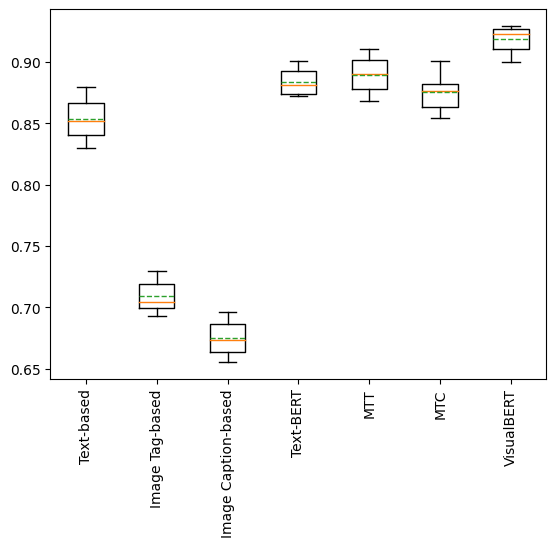

In [54]:
fig, ax = plt.subplots()
ax.boxplot([aucs_text, aucs_tags, aucs_capt, aucs_bert, aucs_MTT, aucs_MTC, aucs_vbert], meanline=True, showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6, 7], ["Text-based", "Image Tag-based", "Image Caption-based", "Text-BERT", "MTT", "MTC", "VisualBERT"], rotation=90)
plt.show()

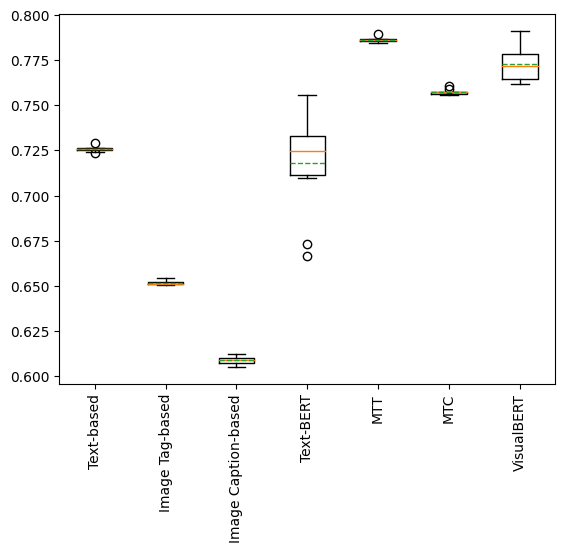

In [55]:

fig, ax = plt.subplots()
ax.boxplot([aucs_text_test, aucs_tags_test, aucs_capt_tags, aucs_bert_test, aucs_MTT_test, aucs_MTC_test, aucs_vbert_test], meanline=True, showmeans=True)
plt.xticks([1, 2, 3, 4, 5, 6, 7], ["Text-based", "Image Tag-based", "Image Caption-based", "Text-BERT", "MTT", "MTC", "VisualBERT"], rotation=90)
plt.show()

In [56]:
aucs_vbert_bias =list({0: 0.8183228518518519, 1: 0.7067193580246913, 2: 0.811590888888889, 3: 0.7874842129629629, 4: 0.8365212539682539, 5: 0.7621710841750842, 6: 0.7467604814814814, 7: 0.8475135238095238, 8: 0.7410681534391533, 9: 0.8056298293650794}.values())
aucs_vbert_bias

[0.8183228518518519,
 0.7067193580246913,
 0.811590888888889,
 0.7874842129629629,
 0.8365212539682539,
 0.7621710841750842,
 0.7467604814814814,
 0.8475135238095238,
 0.7410681534391533,
 0.8056298293650794]

## Load Synthetic

In [57]:
syn_df = load_data.load_syn_identity_data()

In [58]:
annotation_folder = './Annotations/synthetic/'
def get_names_from_ids(iteration):
        f = open(annotation_folder+'test_'+str(iteration)+'.jsonl')
        data = []
        names = []
        for line in f:
                data.append(json.loads(line))
        #data = json.load(f)
        for dict in data:
                names.append(dict['img'].split('.')[0]+'.jpg')
        return names

In [59]:
path_pred_syn = "./VisualBert/Predictions/Synthetic/"
pred_syn=[]
syn_10_df=pd.DataFrame()
i=1
for MODELNAME in MODELNAMES_VISUAL_BERT:
    file_name = ''
    # read the file corresponding to the iteration (we can't no the time-token a priori)
    for file in os.listdir(path_pred_syn):
        if file.endswith(".csv") and file.startswith("syn_" + str(i)+'.'):
            file_name = file
            break
    if file_name == '':
        raise Exception('Predictions for iteration {i} on synthetic data not found.'.format(i=i))
    pred = pd.read_csv(path_pred_syn + file_name, usecols = ['id','proba'])
    pred.columns = ['file_name', MODELNAME]
    
    #syn_10_df['label_'+MODELNAME]=pred[MODELNAME + '_label']
    syn_10_df[MODELNAME]= pred[MODELNAME]
    syn_10_df['file_name']=get_names_from_ids(i)
    syn_10_df=syn_10_df.merge(load_data.load_syn_identity_data()[['misogynous', 'file_name']],
                        how='inner', on='file_name')
    syn_10_df.rename(columns={'misogynous':'label_'+str(i-1)}, inplace=True)#real label associated to the split
    syn_10_df.rename(columns={'file_name':'file_name_'+str(i-1)}, inplace=True)

    i=i+1

In [60]:
path_azure_syn = './Multimodal/predictions/predictions_syn/baseline_multimodal_text_captions_SYN_scores.tsv'
path_azure_BO_syn = './Mitigated/predictions/MTC_syn_10_df.csv'

In [61]:
# Load azure predictions on SYN
pred = pd.read_csv(path_azure_syn, sep='\t').drop(columns=label_column)

a = int(len(pred)/10 )
for i in range(0,10):
    beg = a*i
    end = a*(i+1)
    syn_10_df['multimodal_text_captions_v'+str(i)] = list(pred['multimodal_text_captions_v'+str(i)][beg:end])
syn_10_df.columns

Index(['model_VisualBERT_v0', 'file_name_0', 'label_0', 'model_VisualBERT_v1',
       'file_name_1', 'label_1', 'model_VisualBERT_v2', 'file_name_2',
       'label_2', 'model_VisualBERT_v3', 'file_name_3', 'label_3',
       'model_VisualBERT_v4', 'file_name_4', 'label_4', 'model_VisualBERT_v5',
       'file_name_5', 'label_5', 'model_VisualBERT_v6', 'file_name_6',
       'label_6', 'model_VisualBERT_v7', 'file_name_7', 'label_7',
       'model_VisualBERT_v8', 'file_name_8', 'label_8', 'model_VisualBERT_v9',
       'file_name_9', 'label_9', 'multimodal_text_captions_v0',
       'multimodal_text_captions_v1', 'multimodal_text_captions_v2',
       'multimodal_text_captions_v3', 'multimodal_text_captions_v4',
       'multimodal_text_captions_v5', 'multimodal_text_captions_v6',
       'multimodal_text_captions_v7', 'multimodal_text_captions_v8',
       'multimodal_text_captions_v9'],
      dtype='object')

In [62]:
# Load azure BO predictions on SYN
pred = pd.read_csv(path_azure_BO_syn, usecols=MODELNAMES_M_MTC, sep='\t')
for col in pred.columns:
    syn_10_df[col]=pred[col]
syn_10_df

,model_VisualBERT_v0,file_name_0,label_0,model_VisualBERT_v1,file_name_1,label_1,model_VisualBERT_v2,file_name_2,label_2,model_VisualBERT_v3,...,multimodal_text_captions_BO_v0,multimodal_text_captions_BO_v1,multimodal_text_captions_BO_v2,multimodal_text_captions_BO_v3,multimodal_text_captions_BO_v4,multimodal_text_captions_BO_v5,multimodal_text_captions_BO_v6,multimodal_text_captions_BO_v7,multimodal_text_captions_BO_v8,multimodal_text_captions_BO_v9
0,0.012071,SYN_49.jpg,0,0.996255,SYN_20.jpg,1,0.998068,SYN_40.jpg,0,0.846515,...,0.089251,0.891331,0.407616,0.780110,0.556986,0.501726,0.859859,0.860225,0.969511,0.941125
1,0.026192,SIN_51.jpg,0,0.001039,SIN_170.jpg,1,0.000045,SIN_104.jpg,0,0.991903,...,0.647151,0.664549,0.168989,0.839904,0.871047,0.028915,0.581634,0.940612,0.320404,0.799684
2,0.997714,SYN_69.jpg,0,0.992926,SIN_105.jpg,1,0.981816,SYN_44.jpg,1,0.005895,...,0.220379,0.014468,0.740198,0.009989,0.095283,0.729122,0.998462,0.025532,0.823892,0.793365
3,0.717852,SYN_114.jpg,1,0.996592,SIN_113.jpg,1,0.736905,SIN_41.jpg,1,0.845425,...,0.952061,0.990917,0.971473,0.542988,0.580493,0.603140,0.989025,0.535257,0.003780,0.907331
4,0.959301,SYN_89.jpg,1,0.996598,SYN_14.jpg,0,0.000080,SYN_13.jpg,1,0.916593,...,0.964493,0.828906,0.766104,0.061438,0.378935,0.877839,0.453970,0.519785,0.054727,0.974454
5,0.878191,SYN_121.jpg,0,0.980748,SIN_114.jpg,1,0.010145,SYN_90.jpg,1,0.000382,...,0.119377,0.102780,0.127394,0.027388,0.864355,0.022900,0.947713,0.856871,0.393374,0.436365
6,0.999637,SYN_1.jpg,0,0.751023,SYN_21.jpg,0,0.977857,SYN_4.jpg,0,0.870523,...,0.536092,0.031560,0.603495,0.687838,0.878386,0.007514,0.930981,0.811757,0.807037,0.550162
7,0.004084,SYN_23.jpg,1,0.995678,SYN_80.jpg,1,0.999970,SYN_108.jpg,1,0.001423,...,0.092685,0.647242,0.986107,0.003285,0.210502,0.327350,0.037642,0.872981,0.978534,0.711779
8,0.999221,SYN_10.jpg,1,0.004510,SYN_85.jpg,1,0.000049,SYN_75.jpg,0,0.751444,...,0.921204,0.008743,0.037978,0.753439,0.935790,0.180489,0.820333,0.108910,0.968572,0.875829
9,0.957423,SIN_64.jpg,0,0.993563,SYN_59.jpg,1,0.980057,SIN_11.jpg,0,0.844976,...,0.446291,0.973507,0.560534,0.898820,0.981116,0.012856,0.340941,0.688720,0.909187,0.861869


In [63]:
path_clarifai_syn = './Multimodal/predictions/predictions_syn/baseline_multimodal_text_tags_SYN_scores.tsv'
path_clarifai_BO_syn = './Mitigated/predictions/MTT_syn_10_df.csv'

In [64]:
# Load azure predictions on SYN
pred = pd.read_csv(path_clarifai_syn, sep='\t').drop(columns=label_column)
# reconstruct the syn_10Fold predictions:
a = int(len(pred)/10 )
for i in range(0,10):
    beg = a*i
    end = a*(i+1)
    syn_10_df['multimodal_text_tags_v'+str(i)] = list(pred['multimodal_text_tags_v'+str(i)][beg:end])
syn_10_df.columns

Index(['model_VisualBERT_v0', 'file_name_0', 'label_0', 'model_VisualBERT_v1',
       'file_name_1', 'label_1', 'model_VisualBERT_v2', 'file_name_2',
       'label_2', 'model_VisualBERT_v3', 'file_name_3', 'label_3',
       'model_VisualBERT_v4', 'file_name_4', 'label_4', 'model_VisualBERT_v5',
       'file_name_5', 'label_5', 'model_VisualBERT_v6', 'file_name_6',
       'label_6', 'model_VisualBERT_v7', 'file_name_7', 'label_7',
       'model_VisualBERT_v8', 'file_name_8', 'label_8', 'model_VisualBERT_v9',
       'file_name_9', 'label_9', 'multimodal_text_captions_v0',
       'multimodal_text_captions_v1', 'multimodal_text_captions_v2',
       'multimodal_text_captions_v3', 'multimodal_text_captions_v4',
       'multimodal_text_captions_v5', 'multimodal_text_captions_v6',
       'multimodal_text_captions_v7', 'multimodal_text_captions_v8',
       'multimodal_text_captions_v9', 'multimodal_text_captions_BO_v0',
       'multimodal_text_captions_BO_v1', 'multimodal_text_captions_BO_v2',


In [65]:
# Load azure BO predictions on SYN
pred = pd.read_csv(path_clarifai_BO_syn, usecols=MODELNAMES_M_MTT, sep='\t')
for col in pred.columns:
    syn_10_df[col]=pred[col]
syn_10_df

,model_VisualBERT_v0,file_name_0,label_0,model_VisualBERT_v1,file_name_1,label_1,model_VisualBERT_v2,file_name_2,label_2,model_VisualBERT_v3,...,multimodal_text_tags_BO_v0,multimodal_text_tags_BO_v1,multimodal_text_tags_BO_v2,multimodal_text_tags_BO_v3,multimodal_text_tags_BO_v4,multimodal_text_tags_BO_v5,multimodal_text_tags_BO_v6,multimodal_text_tags_BO_v7,multimodal_text_tags_BO_v8,multimodal_text_tags_BO_v9
0,0.012071,SYN_49.jpg,0,0.996255,SYN_20.jpg,1,0.998068,SYN_40.jpg,0,0.846515,...,0.022264,0.849302,0.931545,0.690724,0.782228,0.860387,0.850078,0.880739,0.925911,0.649766
1,0.026192,SIN_51.jpg,0,0.001039,SIN_170.jpg,1,0.000045,SIN_104.jpg,0,0.991903,...,0.323579,0.603642,0.009011,0.724738,0.939935,0.014559,0.021923,0.792715,0.783678,0.246295
2,0.997714,SYN_69.jpg,0,0.992926,SIN_105.jpg,1,0.981816,SYN_44.jpg,1,0.005895,...,0.101526,0.068318,0.893430,0.054212,0.041387,0.140243,0.981143,0.010277,0.575979,0.723907
3,0.717852,SYN_114.jpg,1,0.996592,SIN_113.jpg,1,0.736905,SIN_41.jpg,1,0.845425,...,0.726078,0.973216,0.936768,0.505499,0.239624,0.705688,0.847039,0.572566,0.266054,0.904904
4,0.959301,SYN_89.jpg,1,0.996598,SYN_14.jpg,0,0.000080,SYN_13.jpg,1,0.916593,...,0.580646,0.928719,0.789841,0.325893,0.310648,0.485413,0.688810,0.986518,0.178393,0.934139
5,0.878191,SYN_121.jpg,0,0.980748,SIN_114.jpg,1,0.010145,SYN_90.jpg,1,0.000382,...,0.031317,0.627413,0.179640,0.110232,0.587033,0.001156,0.874927,0.967661,0.354084,0.273529
6,0.999637,SYN_1.jpg,0,0.751023,SYN_21.jpg,0,0.977857,SYN_4.jpg,0,0.870523,...,0.615158,0.041636,0.708007,0.964272,0.968780,0.003297,0.677516,0.071734,0.875146,0.632462
7,0.004084,SYN_23.jpg,1,0.995678,SYN_80.jpg,1,0.999970,SYN_108.jpg,1,0.001423,...,0.022809,0.740199,0.999283,0.043093,0.182609,0.026354,0.034329,0.789103,0.967846,0.168667
8,0.999221,SYN_10.jpg,1,0.004510,SYN_85.jpg,1,0.000049,SYN_75.jpg,0,0.751444,...,0.844226,0.041548,0.070360,0.704351,0.828553,0.013666,0.324674,0.079673,0.739040,0.925620
9,0.957423,SIN_64.jpg,0,0.993563,SYN_59.jpg,1,0.980057,SIN_11.jpg,0,0.844976,...,0.210285,0.954517,0.819898,0.853221,0.964016,0.014656,0.488108,0.768872,0.738601,0.669022


### Compute Bias metrics

In [66]:
dict={}
aucs={}
bias={}
text={}
image={}
auc_syn={}

In [67]:
MODELFAMILIES_BIAS =  [MODELNAMES_MTT]+ [MODELNAMES_M_MTT] + [MODELNAMES_MTC] + [MODELNAMES_M_MTC] + [MODELNAMES_VISUAL_BERT]

models_bias = []
for x in MODELFAMILIES_BIAS:
    models_bias.append(model_performances.model_family_name(x).split('_v')[0])


In [68]:
from cgi import test

for fam in MODELFAMILIES_BIAS:
     dict[fam[0].split('_v')[0]], aucs[fam[0].split('_v')[0]], bias[fam[0].split('_v')[0]], text[fam[0].split('_v')[0]], image[fam[0].split('_v')[0]], auc_syn[fam[0].split('_v')[0]] = compute_bias_metrics_on_syn_10(fam, syn_10_df, test_df, identity_terms, identity_tags, label_column)


In [69]:
for k in aucs.keys():
    print(k)
    print(np.mean(list(aucs[k].values())))

multimodal_text_tags
0.7861916
multimodal_text_tags_BO
0.8082933999999999
multimodal_text_captions
0.7573665999999999
multimodal_text_captions_BO
0.7799546
model_VisualBERT
0.7728765999999999


## Compute and Plot Bias Metrics

In [70]:
all_aucs=[]
for model in aucs.keys():
    all_aucs.append(list(aucs[model].values()))

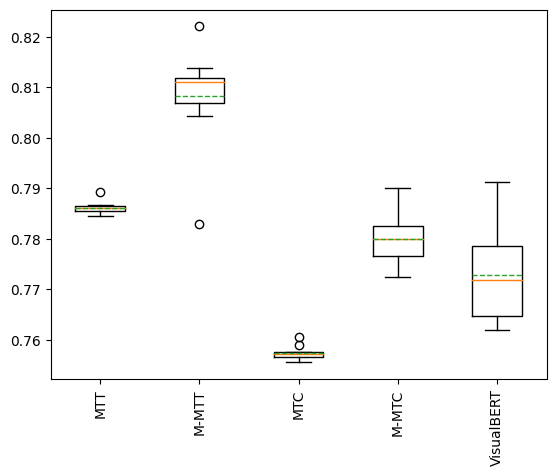

In [71]:
fig, ax = plt.subplots()
ax.boxplot(all_aucs, meanline=True, showmeans=True)
plt.xticks([1, 2, 3, 4, 5], ["MTT","M-MTT", "MTC", "M-MTC", "VisualBERT"], rotation=90)
plt.show()

In [72]:
for k in dict.keys():
    print(k)
    print(np.mean(list(dict[k].values())))

multimodal_text_tags
0.7214094173240341
multimodal_text_tags_BO
0.763443900677409
multimodal_text_captions
0.759676891670675
multimodal_text_captions_BO
0.7863781637966971
model_VisualBERT
0.6948312824033991


In [81]:
for k in bias.keys():
    print(k)
    print(np.mean(list(bias[k].values())))

multimodal_text_tags
0.656627234648068
multimodal_text_tags_BO
0.718594401354818
multimodal_text_captions
0.7619871833413501
multimodal_text_captions_BO
0.7928017275933942
model_VisualBERT
0.6167859648067981


In [73]:
all_bias=[]
for model in models_bias:
    all_bias.append(list(dict[model].values()))

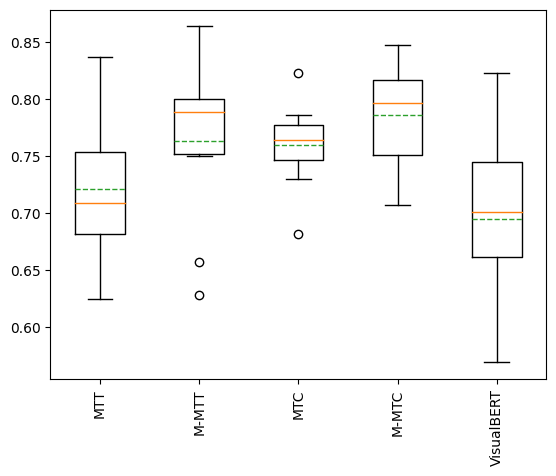

In [74]:
fig, ax = plt.subplots()
ax.boxplot(all_bias, meanline=True, showmeans=True)
plt.xticks([1, 2, 3, 4, 5], ["MTT","M-MTT", "MTC", "M-MTC", "VisualBERT"], rotation=90)
plt.show()

## T-Test
### T-Test on Multimodal-Mitigated

In [75]:
# ___________________________________________t-test on multimodal bias metric (MBE)__________________________________

matrix = np.zeros((len(models_bias), len(models_bias)))
a = 0
for model1 in models_bias:
    b = 0
    for model2 in models_bias:
        # Python paired sample t-test
        test = ttest_rel(list(dict[model1].values()), list(dict[model2].values()))
        matrix[a, b] = test.pvalue
        b = b + 1
    a = a + 1

alpha = 0.05
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(list(dict.keys()))
print(matrix < alpha)

alpha = 0.1
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(list(dict.keys()))
print(matrix < alpha)

t-test on multimodal bias metric, alpha: 0.05
['multimodal_text_tags', 'multimodal_text_tags_BO', 'multimodal_text_captions', 'multimodal_text_captions_BO', 'model_VisualBERT']
[[False False  True  True False]
 [False False False False  True]
 [ True False False  True  True]
 [ True False  True False  True]
 [False  True  True  True False]]
t-test on multimodal bias metric, alpha: 0.1
['multimodal_text_tags', 'multimodal_text_tags_BO', 'multimodal_text_captions', 'multimodal_text_captions_BO', 'model_VisualBERT']
[[False  True  True  True False]
 [ True False False False  True]
 [ True False False  True  True]
 [ True False  True False  True]
 [False  True  True  True False]]


In [108]:
matrix

array([[       nan, 0.08749892, 0.03387146, 0.00890545, 0.20361391],
       [0.08749892,        nan, 0.8600624 , 0.21657068, 0.02562294],
       [0.03387146, 0.8600624 ,        nan, 0.04776851, 0.01668474],
       [0.00890545, 0.21657068, 0.04776851,        nan, 0.00717605],
       [0.20361391, 0.02562294, 0.01668474, 0.00717605,        nan]])

In [109]:
# ___________________________________________t-test on multimodal aucs__________________________________

matrix = np.zeros((len(models_bias), len(models_bias)))
a = 0
for model1 in list(aucs.keys()):
    b = 0
    for model2 in list(aucs.keys()):
        # Python paired sample t-test
        test = ttest_rel(list(aucs[model1].values()), list(aucs[model2].values()))
        matrix[a, b] = test.pvalue
        b = b + 1
    a = a + 1

alpha = 0.05
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(list(aucs.keys()))
print(matrix < alpha)

alpha = 0.1
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(list(aucs.keys()))
print(matrix < alpha)

t-test on multimodal bias metric, alpha: 0.05
['multimodal_text_tags', 'multimodal_text_tags_BO', 'multimodal_text_captions', 'multimodal_text_captions_BO', 'model_VisualBERT']
[[False  True  True  True  True]
 [ True False  True  True  True]
 [ True  True False  True  True]
 [ True  True  True False False]
 [ True  True  True False False]]
t-test on multimodal bias metric, alpha: 0.1
['multimodal_text_tags', 'multimodal_text_tags_BO', 'multimodal_text_captions', 'multimodal_text_captions_BO', 'model_VisualBERT']
[[False  True  True  True  True]
 [ True False  True  True  True]
 [ True  True False  True  True]
 [ True  True  True False  True]
 [ True  True  True  True False]]


In [ ]:
fig, ax = plt.subplots()
ax.boxplot([aucs_MTT_bias, aucs_MTT_BO_bias, aucs_MTC_bias, aucs_MTC_BO_bias, aucs_vbert_bias ], meanline=True, showmeans=True)
plt.xticks([1, 2, 3, 4, 5], ["MTT", "BO_MTT", "MTC", "BO_MTC", "VisualBERT"], rotation=30)
plt.show()

### T-test on unimodal-multimodal

In [88]:
MODELFAMILIES =  [MODELNAMES_TEXT] + [MODELNAMES_TAGS] + [MODELNAMES_CAPTIONS] + [MODELNAMES_BERT] + [MODELNAMES_MTT]+ [MODELNAMES_MTC] + [MODELNAMES_VISUAL_BERT] 

models = []
for x in MODELFAMILIES:
    models.append(model_performances.model_family_name(x).split('_v')[0])


In [89]:
models

['unimodal_text',
 'unimodal_tags',
 'unimodal_captions',
 'model_BERT',
 'multimodal_text_tags',
 'multimodal_text_captions',
 'model_VisualBERT']

In [90]:
# ___________________________________________t-test on aucs metric TRAIN__________________________________

matrix = np.zeros((len(models), len(models)))
a = 0
for model1 in models:
    b = 0
    for model2 in models:
        # Python paired sample t-test
        _, _, aucs1 = performances_report_10Fold(train_df, model1, 0.5)
        _, _, aucs2 = performances_report_10Fold(train_df, model2, 0.5)

        test = ttest_rel(aucs1, aucs2)
        matrix[a, b] = test.pvalue
        b = b + 1
    a = a + 1

alpha = 0.05
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(models)
print(matrix < alpha)

alpha = 0.1
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(models)
print(matrix < alpha)

t-test on multimodal bias metric, alpha: 0.05
['unimodal_text', 'unimodal_tags', 'unimodal_captions', 'model_BERT', 'multimodal_text_tags', 'multimodal_text_captions', 'model_VisualBERT']
[[False  True  True  True  True  True  True]
 [ True False  True  True  True  True  True]
 [ True  True False  True  True  True  True]
 [ True  True  True False False  True  True]
 [ True  True  True False False  True  True]
 [ True  True  True  True  True False  True]
 [ True  True  True  True  True  True False]]
t-test on multimodal bias metric, alpha: 0.1
['unimodal_text', 'unimodal_tags', 'unimodal_captions', 'model_BERT', 'multimodal_text_tags', 'multimodal_text_captions', 'model_VisualBERT']
[[False  True  True  True  True  True  True]
 [ True False  True  True  True  True  True]
 [ True  True False  True  True  True  True]
 [ True  True  True False  True  True  True]
 [ True  True  True  True False  True  True]
 [ True  True  True  True  True False  True]
 [ True  True  True  True  True  True F

In [76]:
# ___________________________________________t-test on aucs metric TEST__________________________________

matrix = np.zeros((len(models), len(models)))
a = 0
for model1 in models:
    b = 0
    for model2 in models:
        # Python paired sample t-test
        _, _, aucs1 = performances_report_10Fold(test_df, model1, 0.5)
        _, _, aucs2 = performances_report_10Fold(test_df, model2, 0.5)

        test = ttest_rel(aucs1, aucs2)
        matrix[a, b] = test.pvalue
        b = b + 1
    a = a + 1

alpha = 0.05
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(models)
print(matrix < alpha)

alpha = 0.1
print('t-test on multimodal bias metric, alpha: {alpha}'.format(alpha=alpha))
print(models)
print(matrix < alpha)

t-test on multimodal bias metric, alpha: 0.05
['multimodal_text_captions_BO', 'multimodal_text_captions', 'multimodal_text_tags', 'multimodal_text_tags_BO', 'model_VisualBERT', 'model_BERT']
[[False  True  True  True False  True]
 [ True False  True  True  True  True]
 [ True  True False  True  True  True]
 [ True  True  True False  True  True]
 [False  True  True  True False  True]
 [ True  True  True  True  True False]]
t-test on multimodal bias metric, alpha: 0.1
['multimodal_text_captions_BO', 'multimodal_text_captions', 'multimodal_text_tags', 'multimodal_text_tags_BO', 'model_VisualBERT', 'model_BERT']
[[False  True  True  True  True  True]
 [ True False  True  True  True  True]
 [ True  True False  True  True  True]
 [ True  True  True False  True  True]
 [ True  True  True  True False  True]
 [ True  True  True  True  True False]]
